# 加载预训练的VAE模型，并打印模型结构

In [2]:
from diffusers import AutoencoderKL
import torch

# 1. 加载预训练的VAE模型
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device)

# 2. 打印模型结构
print(vae)

Using cuda
AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
   

# 加载图片

Original image size: (2160, 2160)


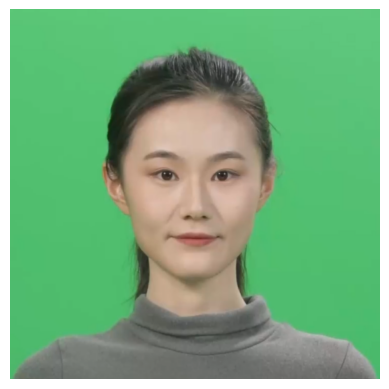

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, Lambda, Resize, ToTensor

# 1. 加载图片
input_image_path = "assets/girl.png"  # 替换为您的图片路径
input_image = Image.open(input_image_path).convert("RGB")

# 2. 打印原始图片尺寸
print(f"Original image size: {input_image.size}")

# 2. 显示图片
plt.imshow(input_image)
plt.axis("off")
plt.show()

# 图片预处理

In [5]:
# 1. 图片预处理
image_size = 512

def preprocess(image, image_size):
    transform = Compose([
        Resize(image_size),
        ToTensor(),
        Lambda(lambda t: (t * 2.0) - 1.0),  # 将图像像素值从[0, 1]缩放到[-1, 1]
    ])
    return transform(image).unsqueeze(0)  # 增加批次维度

input_tensor = preprocess(input_image, image_size)
input_tensor = input_tensor.to(device)

# 2. 打印输入张量的形状
print(input_tensor.shape)

torch.Size([1, 3, 512, 512])


# 用VAE编码，解码图片，并计算L1 loss

In [6]:
import torch

# 1. 编码与解码
with torch.no_grad():
    # 编码
    latents = vae.encode(input_tensor).latent_dist.sample()
    
    # 打印潜在向量的形状
    print("Latents shape:", latents.shape)
    
    # 解码
    output_tensor = vae.decode(latents).sample
    
    # 打印输出张量的形状
    print("Output shape:", output_tensor.shape)

# 2. 计算L1 Loss
l1_loss = torch.nn.functional.l1_loss(input_tensor, output_tensor)

print(f"L1 Loss: {l1_loss.item()}")

Latents shape: torch.Size([1, 4, 64, 64])
Output shape: torch.Size([1, 3, 512, 512])
L1 Loss: 0.01940607652068138


# 创建并显示输出图片

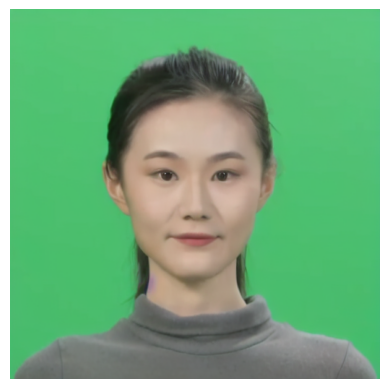

In [7]:
# 1. 创建输出图片
output_image = (output_tensor.squeeze(0).add(1).div(2).clamp(0, 1) * 255).permute(1, 2, 0).byte().cpu().numpy()
output_image = Image.fromarray(output_image)

# 2. 显示输出图片
plt.imshow(output_image)
plt.axis("off")
plt.show()

# 对比输入图片和输出图片

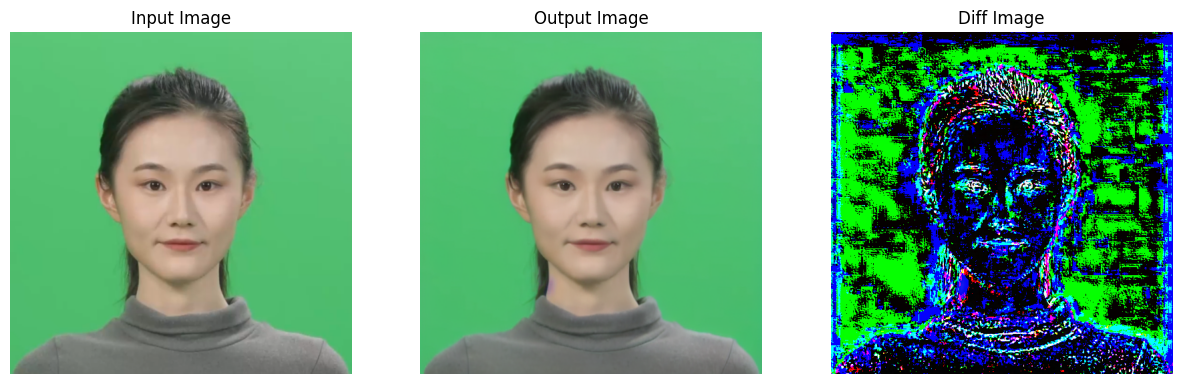

In [8]:
import numpy as np

# 将input_image缩放到image_size
input_image = input_image.resize((image_size, image_size))

# 将 PIL 图片对象转换为 NumPy 数组以便处理
input_image_array = np.asarray(input_image)
output_image_array = np.asarray(output_image)

# 计算差异图片
diff_image_array = np.abs(input_image_array - output_image_array)

# 创建一个图像和子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 显示输入图片
axes[0].imshow(input_image_array)
axes[0].set_title("Input Image")
axes[0].axis("off")

# 显示输出图片
axes[1].imshow(output_image_array)
axes[1].set_title("Output Image")
axes[1].axis("off")

# 显示差异图片
# 注意：为了更好地可视化差异，您可以根据需要调整 diff_image_array 的缩放或映射方式
axes[2].imshow(diff_image_array)
axes[2].set_title("Diff Image")
axes[2].axis("off")

# 显示所有图片
plt.show()